In [11]:
import sys
sys.path.append('/Users/c/Desktop/Desktop_Funnel/anaconda3/lib/python3.9/site-packages')

import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib
matplotlib.use('TkAgg')
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib_inline.backend_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('png')

from scipy.optimize import curve_fit

In [24]:
de_prec = gpd.read_file('DE_precincts.geojson')
de_prec = de_prec[de_prec['TOTAL_REG'] != 0]
viable_races = ['EUR','AA'] # races that have at least one candidate of that race in house
viable_parties = ['DEM', 'REP'] # parties that have at least one candidate of that party in house
colormap = {'DEM':'blue', 'REP':'red'}

def model_function(x, *coeffs):
    y_pred = 0
    for i, coeff in enumerate(coeffs):
        y_pred += coeff * x**i
    return y_pred

[ 0.84531739 -0.59850308]
[ 1.19132709e-02  9.36998127e-01 -5.54502109e+00  1.81494610e+01
 -2.43937581e+01  1.17617660e+01]


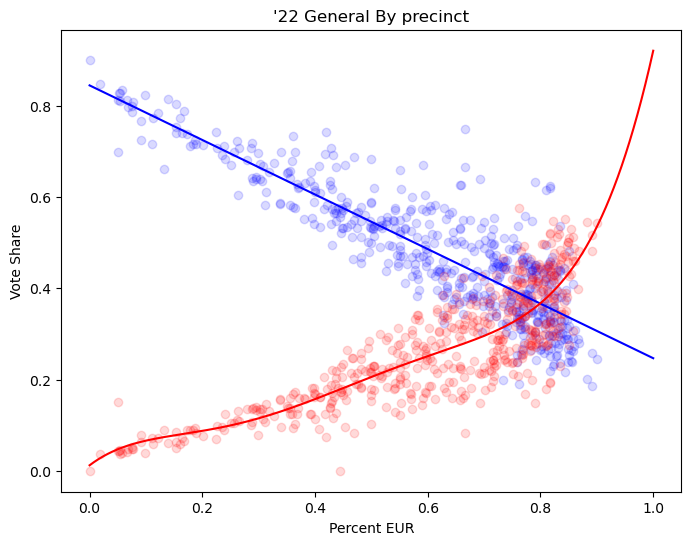

[ 0.37128961  0.36634576  0.81560001 -0.77202485]
[ 0.37368574 -0.61909321  0.27228459]


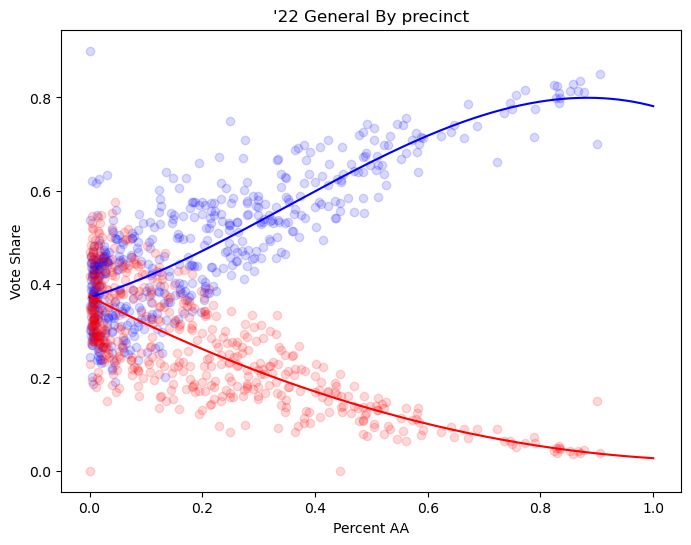

In [31]:
for viable_race in viable_races:
    fig, ax = plt.subplots(figsize=(8, 6))
    for viable_party in viable_parties:
        
        x_data = de_prec[f'ETH1_{viable_race}']/de_prec[f'TOTAL_REG']
        y_data = de_prec[f'PARTY_{viable_party}']/de_prec[f'TOTAL_REG']
        
        # No voters mean no data
        x_data[de_prec['TOTAL_REG'] == 0] = 0
        y_data[de_prec['TOTAL_REG'] == 0] = 0
        
        fitted_params = []
        aic_values = []
        for degree in range(1, 6):
            params, covariance = curve_fit(model_function, x_data, y_data, maxfev=10000, p0=np.ones(degree+1))
            fitted_params.append(params)

            # Calculate the AIC value for the fitted model
            y_pred = model_function(x_data, *params)
            residuals = y_data - y_pred
            rss = np.sum(residuals**2)
            n = len(x_data)
            k = degree + 1  # Number of parameters in the model, penalize for complexity
            aic = n * np.log(rss / n) + 3 * k
            aic_values.append(aic)
        
        # Find the best model based on AIC (lower AIC indicates a better model fit)
        best_degree = np.argmin(aic_values) + 1
        best_params = fitted_params[best_degree - 1]
        print(best_params)
        
        # Generate predictions using the best fitted model
        x = np.linspace(0, 1, 1000)
        y_pred_best = model_function(x, *best_params)
        color = colormap[viable_party]
        ax.scatter(x_data, y_data, alpha=.15, color=color, label='Original Data')
        ax.plot(x, y_pred_best, color=color, label=f'Best Fit (Degree {best_degree})')
        
    ax.set_xlabel(f'Percent {viable_race}')
    ax.set_ylabel('Vote Share')
    ax.set_title(f"'22 General By precinct")
    plt.show()